# PREPROCESSING

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from scipy.stats import norm
import random as rand
import pickle

filehandler = open(b"Data/train_dv.obj","rb")
df = pickle.load(filehandler)
filehandler.close()

In [3]:
#Removing columns & missing value rows
df = df.drop(['Ticket','Cabin'], axis=1)

In [4]:
#transform category data into numerical 
#hack for seaborn heatmap (no support for categorical values) 
df['Sex'] = [0 if x == 'male' else 1 for x in df['Sex'] ]

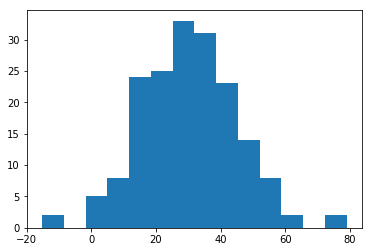

In [5]:
#Replace Age missing values with data generated from gaussian
nan_filter = df['Age'].isnull()
np.random.seed(666)
mu, sigma = norm.fit(df[-nan_filter]['Age'])
norm_dist = np.random.normal(mu, sigma, nan_filter.sum())

plt.hist(norm_dist,bins='auto')

df.loc[nan_filter,'Age'] = norm_dist